# 1) Librerías y configuración

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Configuraciones globales
IMG_SIZE = 224
DATA_DIR = "Dataset/"
CATEGORIES = os.listdir(DATA_DIR)

print(f"Categorías detectadas:\n")
for _ in CATEGORIES:
    print(_)

Categorías detectadas:

Anthracnose
Bacterial Blight
Citrus Canker
Curl Virus
Deficiency Leaf
Dry Leaf
Healthy Leaf
Sooty Mould
Spider Mites


# 2) Preprocesamiento con filtro Top-hat y Gaussiano

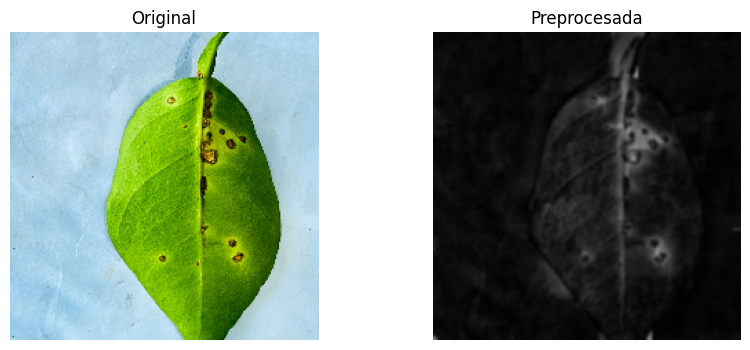

In [3]:
def preprocess_image(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15,15))
    tophat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, kernel)
    blurred = cv2.GaussianBlur(tophat, (5,5), 0)
    final = cv2.merge([blurred, blurred, blurred])
    return final

# Prueba con una imagen aleatoria
sample_path = os.path.join(DATA_DIR, CATEGORIES[0], os.listdir(os.path.join(DATA_DIR, CATEGORIES[0]))[0])
img = cv2.imread(sample_path)
img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
img_preprocessed = preprocess_image(img_resized)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
plt.title("Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img_preprocessed, cv2.COLOR_BGR2RGB), cmap='gray')
plt.title("Preprocesada")
plt.axis("off")
plt.show()


# 3) Cargar todas las imágenes y preprocesarlas

In [4]:
data = []
labels = []

for idx, category in enumerate(CATEGORIES):
    folder = os.path.join(DATA_DIR, category)
    for file in os.listdir(folder):
        path = os.path.join(folder, file)
        img = cv2.imread(path)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        processed_img = preprocess_image(img)
        data.append(processed_img)
        labels.append(idx)

data = np.array(data) / 255.0
labels = to_categorical(labels)

print(f"Total de imágenes cargadas: {len(data)}")
print(f"Shape de las imágenes: {data[0].shape}")


Total de imágenes cargadas: 1354
Shape de las imágenes: (224, 224, 3)


# 4) Separar train/test y visualizar muestras

Tamaño del set de entrenamiento: (1083, 224, 224, 3)
Tamaño del set de prueba: (271, 224, 224, 3)


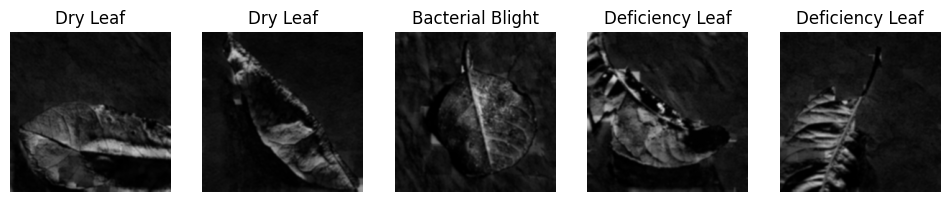

In [5]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

print(f"Tamaño del set de entrenamiento: {X_train.shape}")
print(f"Tamaño del set de prueba: {X_test.shape}")

# Visualización de muestras por clase
def plot_examples(X, y, n=5):
    plt.figure(figsize=(12, 3))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(X[i])
        label = np.argmax(y[i])
        plt.title(CATEGORIES[label])
        plt.axis("off")
    plt.show()

plot_examples(X_train, y_train)


# 5) Aumento de datos con ImageDataGenerator

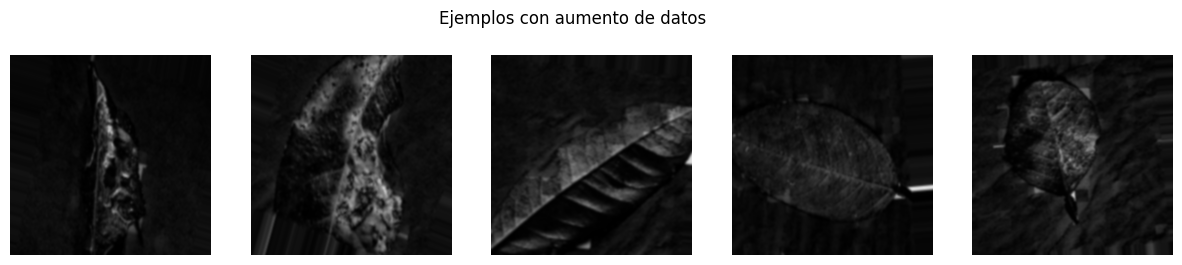

In [6]:
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)

# Mostrar algunas imágenes aumentadas
fig, axs = plt.subplots(1, 5, figsize=(15,3))
for X_batch, _ in datagen.flow(X_train, y_train, batch_size=5):
    for i in range(5):
        axs[i].imshow(X_batch[i])
        axs[i].axis("off")
    break
plt.suptitle("Ejemplos con aumento de datos")
plt.show()


# 6) Definir y compilar el modelo CNN

In [7]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(CATEGORIES), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


c:\Users\USUARIO\Desktop\Proyecto AML Local\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    23,888,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,908,553 (91.20 MB)

 Trainable params: 23,908,553 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

# 7) Entrenamiento del modelo

In [8]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    epochs=30)


c:\Users\USUARIO\Desktop\Proyecto AML Local\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 256ms/step - accuracy: 0.2119 - loss: 2.1257 - val_accuracy: 0.3358 - val_loss: 1.7432
Epoch 2/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 257ms/step - accuracy: 0.3660 - loss: 1.7543 - val_accuracy: 0.4686 - val_loss: 1.4737
Epoch 3/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 283ms/step - accuracy: 0.4190 - loss: 1.5902 - val_accuracy: 0.4428 - val_loss: 1.4146
Epoch 4/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 265ms/step - accuracy: 0.4560 - loss: 1.5220 - val_accuracy: 0.5129 - val_loss: 1.3301
Epoch 5/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 254ms/step - accuracy: 0.4422 - loss: 1.5211 - val_accuracy: 0.5424 - val_loss: 1.3168
Epoch 6/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 285ms/step - accuracy: 0.4708 - loss: 1.4460 - val_accuracy: 0.5793 - val_loss: 1.2135
Epoch 7/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 276ms/step - accuracy: 0.5038 - loss: 1.3999 - val_accuracy: 0.5793 - val_loss: 1.1613
Epoch 8/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 259ms/step - accuracy: 0.5112 - loss: 1.3616 - val_accuracy:

# 8) Evaluar y visualizar desempeño

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6627 - loss: 0.8531
Precisión en test: 66.42%


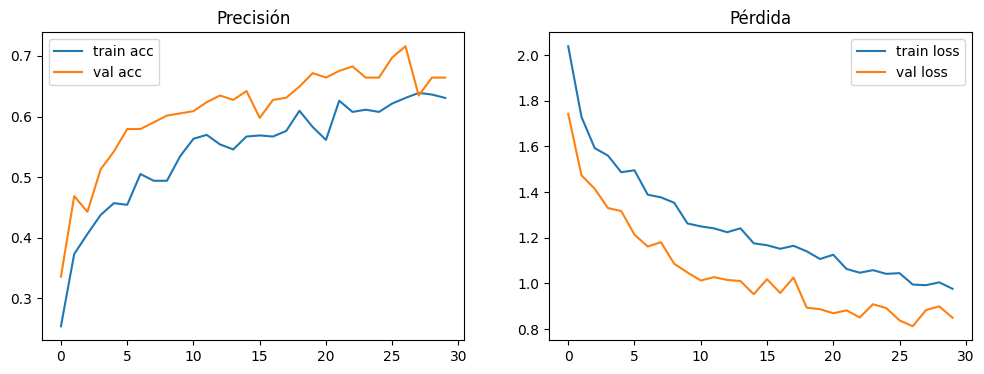

In [9]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Precisión en test: {acc * 100:.2f}%")

# Graficar curvas de pérdida y accuracy
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title("Precisión")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title("Pérdida")
plt.legend()

plt.show()


## 8.1) Matriz de confusión

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


<Figure size 1000x800 with 0 Axes>

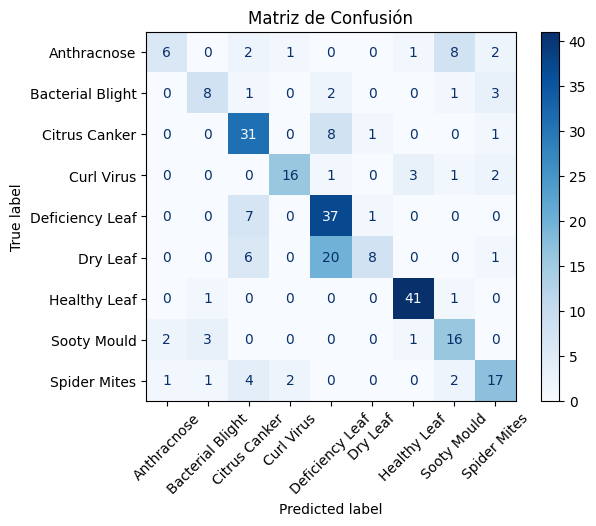

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Predicciones de clase
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CATEGORIES)

plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Matriz de Confusión")
plt.show()


## 8.2) Clasificación por clase (precision, recall, f1-score)

In [11]:
from sklearn.metrics import classification_report

print("Reporte de Clasificación por clase:\n")
report = classification_report(y_true, y_pred, target_names=CATEGORIES)
print(report)


Reporte de Clasificación por clase:

                  precision    recall  f1-score   support

     Anthracnose       0.67      0.30      0.41        20
Bacterial Blight       0.62      0.53      0.57        15
   Citrus Canker       0.61      0.76      0.67        41
      Curl Virus       0.84      0.70      0.76        23
 Deficiency Leaf       0.54      0.82      0.65        45
        Dry Leaf       0.80      0.23      0.36        35
    Healthy Leaf       0.89      0.95      0.92        43
     Sooty Mould       0.55      0.73      0.63        22
    Spider Mites       0.65      0.63      0.64        27

        accuracy                           0.66       271
       macro avg       0.69      0.63      0.62       271
    weighted avg       0.69      0.66      0.64       271



# 8.3) Visualizar imágenes mal clasificadas

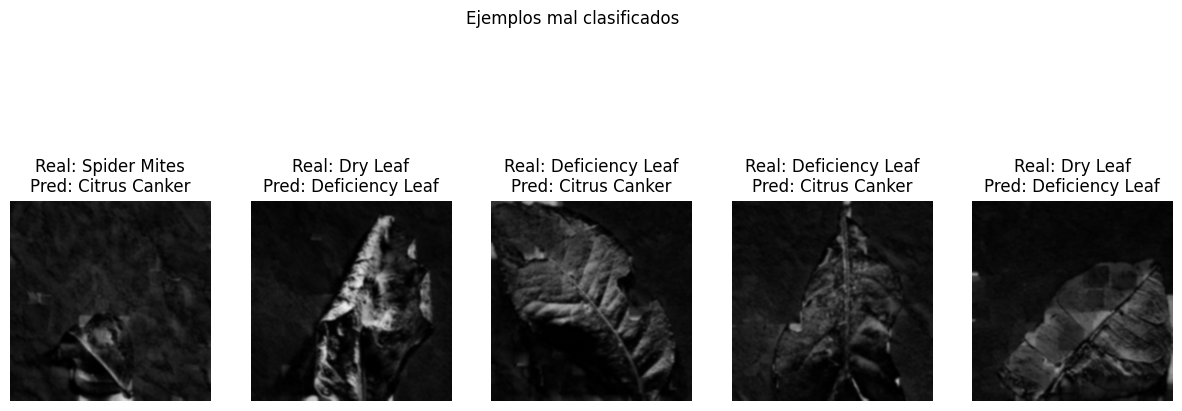

In [12]:
wrong_idx = np.where(y_pred != y_true)[0]

plt.figure(figsize=(15, 6))
for i, idx in enumerate(wrong_idx[:5]):  # mostrar solo 5 ejemplos
    plt.subplot(1, 5, i+1)
    plt.imshow(X_test[idx])
    plt.title(f"Real: {CATEGORIES[y_true[idx]]}\nPred: {CATEGORIES[y_pred[idx]]}")
    plt.axis("off")
plt.suptitle("Ejemplos mal clasificados")
plt.show()


# 8.4) Distribución de predicciones por clase

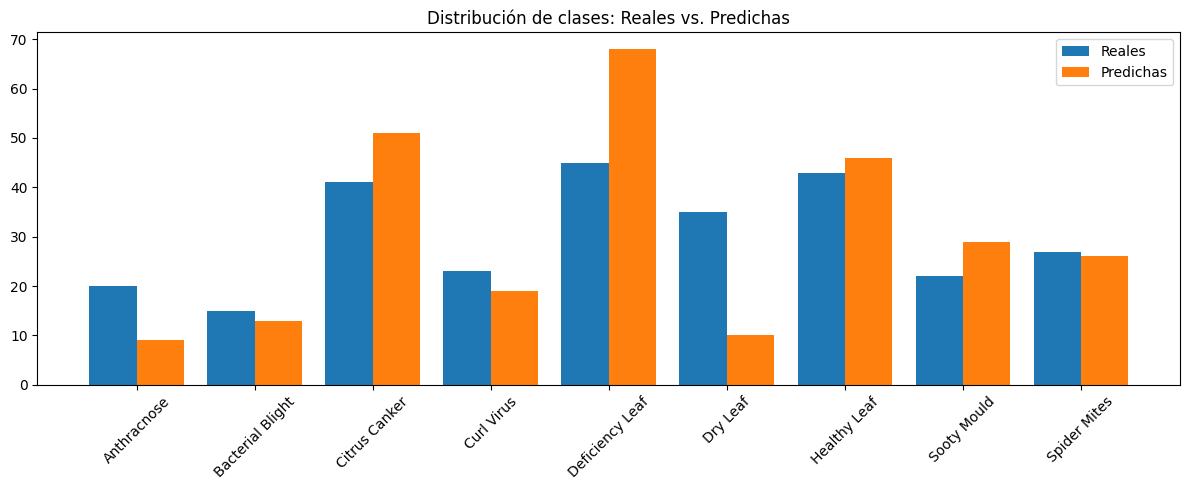

In [13]:
import pandas as pd

# Contar predicciones por clase
pred_counts = pd.Series(y_pred).value_counts().sort_index()
true_counts = pd.Series(y_true).value_counts().sort_index()

plt.figure(figsize=(12,5))
bar_width = 0.4
x = np.arange(len(CATEGORIES))

plt.bar(x - bar_width/2, true_counts, width=bar_width, label='Reales')
plt.bar(x + bar_width/2, pred_counts, width=bar_width, label='Predichas')
plt.xticks(ticks=x, labels=CATEGORIES, rotation=45)
plt.title("Distribución de clases: Reales vs. Predichas")
plt.legend()
plt.tight_layout()
plt.show()


# 9) Instalar y cargar Keras Tuner (solo la primera vez)

In [14]:
import keras_tuner as kt
from tensorflow.keras import optimizers, callbacks

# 10) Definir la función build_model(hp) con los hiperparámetros a explorar

In [15]:
def build_model(hp):
    model = Sequential()
    
    # ↓––– Capa Conv 1 –––↓
    hp_filters_1 = hp.Choice('filters_1', values=[32, 48, 64, 96])
    model.add(Conv2D(hp_filters_1,
                     kernel_size=3,
                     activation='relu',
                     input_shape=(IMG_SIZE, IMG_SIZE, 3)))
    model.add(MaxPooling2D(2, 2))
    
    # ↓––– Capa Conv 2 –––↓
    hp_filters_2 = hp.Choice('filters_2', values=[64, 96, 128, 160])
    model.add(Conv2D(hp_filters_2, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(2, 2))
    
    # ↓––– Capas adicionales opcionales –––↓
    if hp.Boolean('conv3'):
        hp_filters_3 = hp.Choice('filters_3', values=[128, 160, 192])
        model.add(Conv2D(hp_filters_3, kernel_size=3, activation='relu'))
        model.add(MaxPooling2D(2, 2))
    
    model.add(Flatten())
    
    # ↓––– Capa densa –––↓
    hp_units = hp.Int('dense_units', min_value=64, max_value=512, step=64)
    model.add(Dense(hp_units, activation='relu'))
    
    # ↓––– Dropout –––↓
    hp_dropout = hp.Float('dropout_rate', min_value=0.2, max_value=0.6, step=0.1)
    model.add(Dropout(hp_dropout))
    
    # Capa salida
    model.add(Dense(len(CATEGORIES), activation='softmax'))
    
    # ↓––– Optimizador + LR –––↓
    hp_lr = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
    optimizer = optimizers.Adam(learning_rate=hp_lr)
    
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# 11) Configurar el buscador (RandomSearch o Bayesian). Aquí usamos RandomSearch.

In [16]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,            # intenta 20 combinaciones
    executions_per_trial=1,   # 1 ejecución por combinación
    directory='ktuner_proyecto_ml',
    project_name='clasificador_hojas'
)

tuner.search_space_summary()

Search space summary
Default search space size: 6
filters_1 (Choice)
{'default': 32, 'conditions': [], 'values': [32, 48, 64, 96], 'ordered': True}
filters_2 (Choice)
{'default': 64, 'conditions': [], 'values': [64, 96, 128, 160], 'ordered': True}
conv3 (Boolean)
{'default': False, 'conditions': []}
dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 512, 'step': 64, 'sampling': 'linear'}
dropout_rate (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.6, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


c:\Users\USUARIO\Desktop\Proyecto AML Local\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# 12) Lanzar la búsqueda

In [17]:
stop_early = callbacks.EarlyStopping(monitor='val_loss',
                                     patience=5,
                                     restore_best_weights=True)

tuner.search(datagen.flow(X_train, y_train, batch_size=32),
             validation_data=(X_test, y_test),
             epochs=30,
             callbacks=[stop_early])

Trial 20 Complete [00h 08m 03s]
val_accuracy: 0.6014760136604309

Best val_accuracy So Far: 0.8007380366325378
Total elapsed time: 03h 15m 46s


# 13) Resultados y mejor modelo



In [18]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Mejores hiperparámetros encontrados:")
for p in best_hps.values:
    print(f"  {p}: {best_hps.get(p)}")

# Reconstruir y entrenar el mejor modelo (con EarlyStopping & LR Scheduler opcional)
best_model = tuner.hypermodel.build(best_hps)
history_best = best_model.fit(datagen.flow(X_train, y_train, batch_size=32),
                              validation_data=(X_test, y_test),
                              epochs=50,
                              callbacks=[stop_early])

# Evaluar
loss_best, acc_best = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Precisión del mejor modelo en test: {acc_best*100:.2f}%")

Mejores hiperparámetros encontrados:
  filters_1: 64
  filters_2: 128
  conv3: True
  dense_units: 512
  dropout_rate: 0.2
  learning_rate: 0.0003133857760621912
  filters_3: 192
Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 23s 660ms/step - accuracy: 0.1615 - loss: 2.1398 - val_accuracy: 0.3727 - val_loss: 1.6789
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 22s 644ms/step - accuracy: 0.4082 - loss: 1.6641 - val_accuracy: 0.4723 - val_loss: 1.3841
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 22s 647ms/step - accuracy: 0.4522 - loss: 1.4850 - val_accuracy: 0.4982 - val_loss: 1.2861
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 22s 654ms/step - accuracy: 0.5158 - loss: 1.3388 - val_accuracy: 0.5351 - val_loss: 1.2455
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 22s 645ms/step - accuracy: 0.5427 - loss: 1.2909 - val_accuracy: 0.5830 - val_loss: 1.1901
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 22s 650ms/step - accuracy: 0.5491 - loss: 1.2677 - val_accuracy: 0.6162 - val_loss: 1.1778
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 23s 672ms

# 14) Comparar curvas de entrenamiento (opcional)


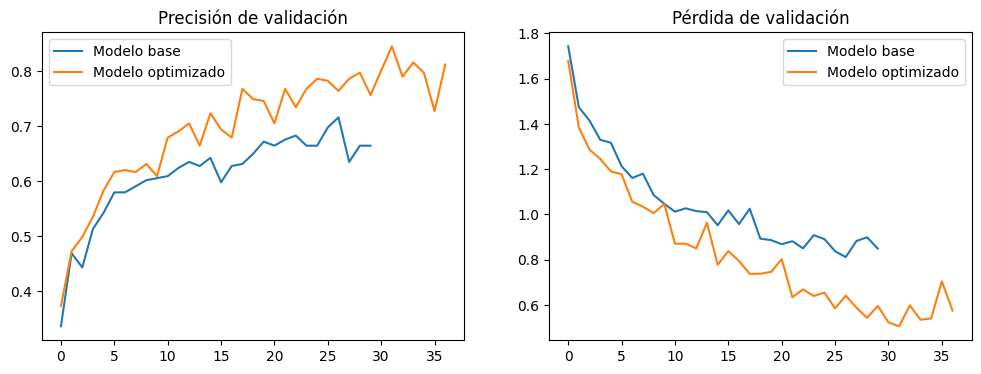

In [19]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['val_accuracy'], label='Modelo base')
plt.plot(history_best.history['val_accuracy'], label='Modelo optimizado')
plt.title("Precisión de validación")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['val_loss'], label='Modelo base')
plt.plot(history_best.history['val_loss'], label='Modelo optimizado')
plt.title("Pérdida de validación")
plt.legend()

plt.show()

# 15) Guardar el modelo óptimo


In [20]:
best_model.save("cnn_hojas_hiperparametros.h5")
print("Modelo optimizado guardado como cnn_hojas_hiperparametros.h5")

Modelo optimizado guardado como cnn_hojas_hiperparametros.h5


# 16) Carga h5 y evaluación

In [21]:
from tensorflow.keras.models import load_model

# Cargar modelo desde archivo .h5
best_model = load_model("cnn_hojas_hiperparametros.h5")
print("Modelo cargado exitosamente.")

# Evaluar el modelo cargado
loss, acc = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Precisión del modelo cargado: {acc * 100:.2f}%")

Modelo cargado exitosamente.
Precisión del modelo cargado: 84.50%


# 17) Guardar el modelo óptimo con pickle

In [24]:
import pickle

# Solo si estás seguro de que este es el mejor modelo
best_weights = best_model.get_weights()

with open("mejor_pesos.pkl", "wb") as f:
    pickle.dump(best_weights, f)

# Guardar arquitectura del modelo como JSON
model_json = best_model.to_json()

with open("mejor_modelo.json", "w") as f:
    f.write(model_json)

print("Arquitectura guardada como mejor_modelo.json")

Arquitectura guardada como mejor_modelo.json


# 18) Carga Pickle y evaluación

In [26]:
from tensorflow.keras.models import model_from_json

# Cargar arquitectura
with open("mejor_modelo.json", "r") as f:
    model_loaded = model_from_json(f.read())

# Cargar pesos
with open("mejor_pesos.pkl", "rb") as f:
    loaded_weights = pickle.load(f)

model_loaded.set_weights(loaded_weights)
print("Modelo reconstruido correctamente desde JSON y pesos .pkl")

# Evaluar el modelo cargado
loss, acc = model_loaded.evaluate(X_test, y_test, verbose=0)
print(f"Precisión del modelo cargado: {acc * 100:.2f}%")

Modelo reconstruido correctamente desde JSON y pesos .pkl
Precisión del modelo cargado: 84.50%


# 19) Evaluar y visualizar desempeño con best_model

Precisión en test (best_model): 84.50%


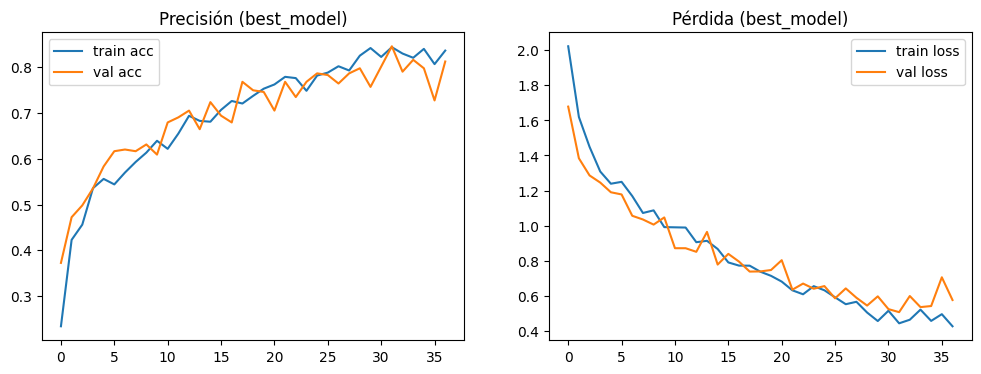

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step


<Figure size 1000x800 with 0 Axes>

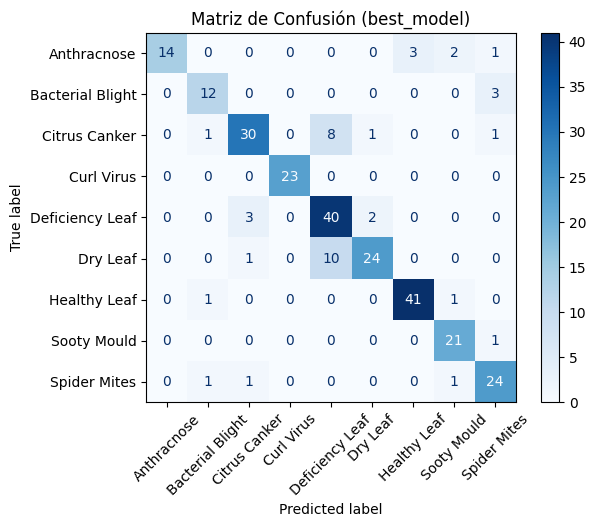

Reporte de Clasificación por clase (best_model):

                  precision    recall  f1-score   support

     Anthracnose       1.00      0.70      0.82        20
Bacterial Blight       0.80      0.80      0.80        15
   Citrus Canker       0.86      0.73      0.79        41
      Curl Virus       1.00      1.00      1.00        23
 Deficiency Leaf       0.69      0.89      0.78        45
        Dry Leaf       0.89      0.69      0.77        35
    Healthy Leaf       0.93      0.95      0.94        43
     Sooty Mould       0.84      0.95      0.89        22
    Spider Mites       0.80      0.89      0.84        27

        accuracy                           0.85       271
       macro avg       0.87      0.84      0.85       271
    weighted avg       0.86      0.85      0.84       271



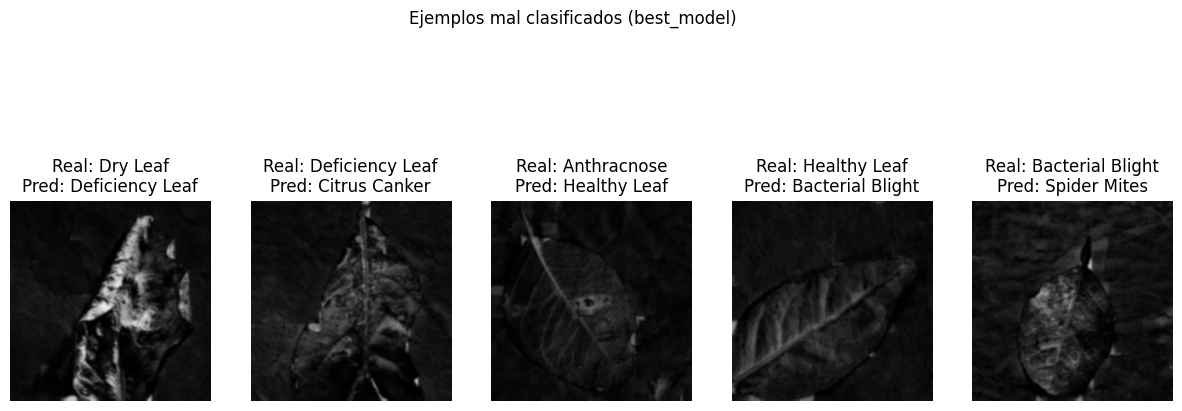

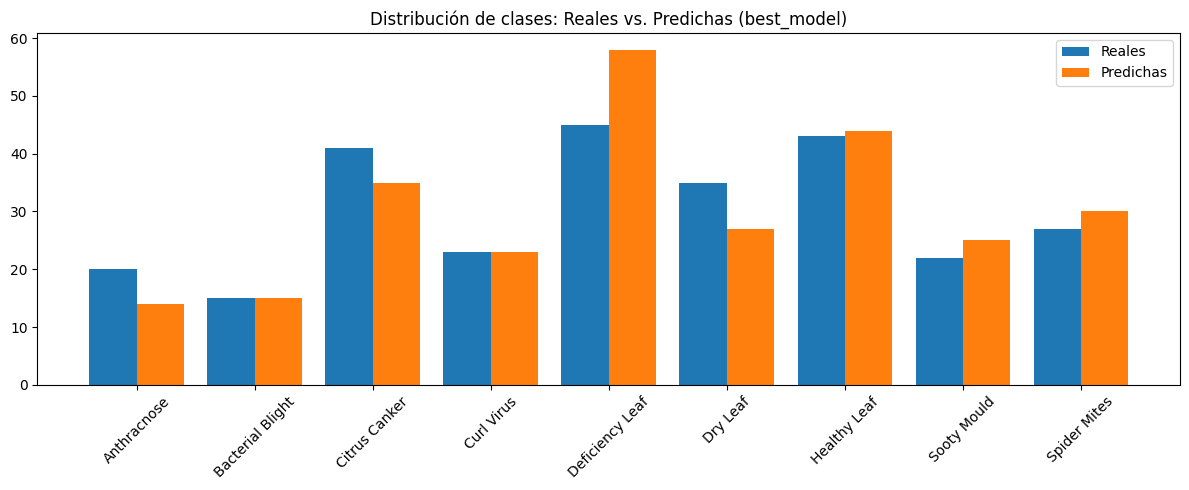

In [27]:
# 1) Precisión y pérdida
loss_best, acc_best = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Precisión en test (best_model): {acc_best * 100:.2f}%")

# 2) Curvas de entrenamiento (si entrenaste en esta sesión y quedó history_best)
if 'history_best' in globals():
    plt.figure(figsize=(12,4))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history_best.history['accuracy'], label='train acc')
    plt.plot(history_best.history['val_accuracy'], label='val acc')
    plt.title("Precisión (best_model)")
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history_best.history['loss'], label='train loss')
    plt.plot(history_best.history['val_loss'], label='val loss')
    plt.title("Pérdida (best_model)")
    plt.legend()

    plt.show()
else:
    print("No se encontró history_best – omite curvas de entrenamiento.")

# 3) Matriz de confusión
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import seaborn as sns

y_pred_probs_best = best_model.predict(X_test)
y_pred_best = np.argmax(y_pred_probs_best, axis=1)
y_true = np.argmax(y_test, axis=1)

cm_best = confusion_matrix(y_true, y_pred_best)
disp_best = ConfusionMatrixDisplay(confusion_matrix=cm_best, display_labels=CATEGORIES)

plt.figure(figsize=(10, 8))
disp_best.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Matriz de Confusión (best_model)")
plt.show()

# 4) Reporte de clasificación
print("Reporte de Clasificación por clase (best_model):\n")
print(classification_report(y_true, y_pred_best, target_names=CATEGORIES))

# 5) Imágenes mal clasificadas
wrong_idx_best = np.where(y_pred_best != y_true)[0]

plt.figure(figsize=(15, 6))
for i, idx in enumerate(wrong_idx_best[:5]):  # mostrar 5 ejemplos
    plt.subplot(1, 5, i+1)
    plt.imshow(X_test[idx])
    plt.title(f"Real: {CATEGORIES[y_true[idx]]}\nPred: {CATEGORIES[y_pred_best[idx]]}")
    plt.axis("off")
plt.suptitle("Ejemplos mal clasificados (best_model)")
plt.show()

# 6) Distribución de predicciones por clase
import pandas as pd

pred_counts_best = pd.Series(y_pred_best).value_counts().sort_index()
true_counts_best = pd.Series(y_true).value_counts().sort_index()

plt.figure(figsize=(12,5))
bar_width = 0.4
x = np.arange(len(CATEGORIES))

plt.bar(x - bar_width/2, true_counts_best, width=bar_width, label='Reales')
plt.bar(x + bar_width/2, pred_counts_best, width=bar_width, label='Predichas')
plt.xticks(ticks=x, labels=CATEGORIES, rotation=45)
plt.title("Distribución de clases: Reales vs. Predichas (best_model)")
plt.legend()
plt.tight_layout()
plt.show()
